# Load Libraries and Functions

In [1]:
# System, Data, Time, and Spec Libraries
import os
import pandas as pd
import time
import random
from datetime import datetime, timedelta
import numpy as np 
from line_profiler import LineProfiler  # Code peformance
profiler = LineProfiler()
import warnings
warnings.filterwarnings('ignore')
import csv
#pd.set_option('display.max_colwidth', None)
import multiprocess as mp
num_cores = mp.cpu_count()

# Data Visualization Libraries
import matplotlib.pyplot as plt
from tabulate import tabulate
import plotly.express as px
import seaborn as sns
#from pandas.io.json import json_normalize  # Older version
from pandas import json_normalize  # Newer version
from pandas.plotting import parallel_coordinates


# Natural Language Processing Libraries
import json
import requests
import xml.etree.ElementTree as ET
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import words
import string
import nltk
from collections import OrderedDict
from nltk.tokenize import word_tokenize
from pandas import json_normalize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.util import ngrams
from nltk.corpus import stopwords
from string import punctuation
punctuation = set(punctuation)
punctuation.update({'_', '-','‘'})
english_words = set(words.words())
from fuzzywuzzy import process
#nltk.download('words')
#nltk.download('punkt')
#nltk.download('stopwords')

# SQL Interface Libraries
import pymysql as mysql
import mysql.connector
import pyodbc
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import event
from string import punctuation

# Machine Learning Libraries
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats import yeojohnson
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay,roc_auc_score, roc_curve 
from sklearn.metrics import classification_report, mean_squared_error, f1_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from dmba import classificationSummary, AIC_score, BIC_score, plotDecisionTree,gainsChart
from scikitplot.metrics import plot_lift_curve, plot_cumulative_gain
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.metrics import specificity_score, sensitivity_score
from imblearn.under_sampling import RandomUnderSampler
from scikitplot.metrics import plot_lift_curve
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import cross_val_score
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
from dmba import stepwise_selection, classificationSummary, backward_elimination
from sklearn.decomposition import PCA
from sklearn.utils.random import sample_without_replacement
from sklearn.metrics import precision_score, recall_score

# Importing Custom Functions
import nbimporter
from Functions import nan_info

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

no display found. Using non-interactive Agg backend


# Test Join Outside of Database

In [3]:
# df1 = pd.read_csv('C://Users/halee/Downloads/events_table2024.csv')
# df2 = pd.read_csv('C://Users/halee/Downloads/drugs_table2024_prep.csv')
# # Merge df1 and df2
# merged_df1_df2 = pd.merge(df1, df2, on='event_id', how='inner')
# merged_df1_df2.drop(['patient_drug_id'], axis = 1, inplace = True)
# merged_df1_df2.drop_duplicates(inplace=True)
# merged_df1_df2.head(20)

In [4]:
# merged_df1_df2['ndc9'] = merged_df1_df2['ndc9'].astype(str)
# merged_df1_df2['ndc9'].head()

In [5]:
# with_drugs = merged_df1_df2[['event_id', 'expedited', 'age', 'sex', 'weight', 'report_source', 'ndc9', 'serious_outcome']].drop_duplicates(subset='event_id')

In [7]:
#with_drugs.head()

In [ ]:
with_drugs.to_csv('C://Users/halee/Downloads/with_drugs_sample2024.csv', index = False)

### SQL Password

In [6]:
PASSWORD  = 'PASSWORD' 

## Investigate number of records in each database table

In [64]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT COUNT(*) FROM patient_reactions"""


cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]


result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

,COUNT(*)
0,118510


# Get Dataset from SQL Database

In [65]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create a cursor object
cursor = connection.cursor()

In [66]:
# # Master Query from Data - goal

# master_query = """SELECT 
#                 a.serious_outcome,
#                 a.expedited,
#                 a.age,
#                 a.sex,
#                 a.year
#                 a.weight
#                 r.outcome,
#                 p.unit_price,
#                 p.generic_brand,
#                 l.ingredients,
#                 l.rxcui,
#                 l.set_id,
#                 d.manu_num,
#                 d.unii
#             FROM adverse_events a 
#                 INNER JOIN patients_reactions r ON a.event_id = r.event_id 
#                 INNER JOIN patients_drugs d ON r.event_id = d.event_id 
#                 INNER JOIN prices p ON d.ndc11 = p.ndc11
#                 INNER JOIN lables l ON p.ndc11 = l.ndc11
#             ORDER BY a.event_id DESC"""  # Still need to test and figure out

# Read in data from csv OR

In [8]:
master_query_df = pd.read_csv('DataLibrary/result_query_df.csv')

# option 2- Read in data from SQL

In [ ]:
start_time = time.time()

connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

#temp removed a.expedited,

cursor = connection.cursor()
sql_query = """SELECT 
d.med_product,
d.event_id,
d.manu_num,
a.serious_outcome,
a.age,
a.sex,
a.year,
a.weight,
a.report_source,
r.outcome,
d.ndc9,
p.unit_price
FROM adverse_events a 

INNER JOIN patient_reactions r ON a.event_id = r.event_id
INNER JOIN patient_drugs d ON a.event_id = d.event_id
LEFT JOIN prices p ON d.ndc9 = p.ndc9
ORDER BY a.event_id DESC
"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
master_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()


end_time = time.time()
execution_time = end_time - start_time
print(execution_time)



master_query_df = master_query_df.drop_duplicates()


master_query_df['unit_price'] = master_query_df['unit_price'].replace({None: np.nan})

# Calculate the median of the 'unit_price' column, ignoring NaN values
median_unit_price = master_query_df['unit_price'].median()

# Replace NaN values in 'unit_price' with the calculated median
master_query_df['unit_price'] = master_query_df['unit_price'].fillna(median_unit_price)
#master_query_df = master_query_df[master_query_df['expedited'] != 5]

master_query_df.head(10)


master_query_df.to_csv('DataLibrary/result_query_2024_withImputedprices.csv')

[CV] END ...................................n_estimators=100; total time=   8.1s
[CV] END ...................................n_estimators=125; total time=   9.0s
[CV] END ...................................n_estimators=175; total time=  12.2s
[CV] END ...................................n_estimators=100; total time=   8.1s
[CV] END ...................................n_estimators=150; total time=  10.8s
[CV] END ...................................n_estimators=175; total time=  11.6s
[CV] END ...................................n_estimators=100; total time=   8.3s
[CV] END ...................................n_estimators=150; total time=  10.4s
[CV] END ...................................n_estimators=175; total time=  12.1s
[CV] END ...................................n_estimators=100; total time=   8.4s
[CV] END ...................................n_estimators=150; total time=  10.7s
[CV] END ...................................n_estimators=200; total time=  13.0s
[CV] END ...................

In [ ]:

master_query_df.shape

In [ ]:
master_query_df.head()

In [ ]:
#master_query_df.to_csv('DataLibrary/result_query_df.csv')

In [ ]:
master_query_df.shape

# Make dataset smaller for testing

# Preparation for Data Split

In [ ]:
#with_drugs = pd.read_csv('/Users/vicky/Downloads/with_drugs_sample2024.csv')

### Define numerical, text, and categorical variables

In [ ]:
#with_drugs.info()

In [ ]:
result_query_df = master_query_df

In [ ]:
result_query_df.shape

In [ ]:
cats = ['sex', 'report_source', 'ndc9']
nums = ['weight', 'age', 'unit_price']  # Took out year since data will all be from recent 3 months of data 
all_vars = cats+nums

#Define outcome as categorical
result_query_df['serious_outcome'] = result_query_df['serious_outcome'].astype('category')

result_query_df.head()

### Create Transformation Pipeline

### One Hot Encode Drug Names for Full Dataset before Splitting - using NDC9 since there is only one per row

In [ ]:
# need to do 


In [ ]:
# # Create a categorical processing pipeline that uses one-hot encoding
# # Dropping binary columns and drop first of each level** NEED TO ADD**
# cat_pipe = Pipeline([('encoder', OneHotEncoder(drop='if_binary'))])

# # Create a numerical processing pipeline that uses skewness correction/center/scale.
# num_pipe = Pipeline([('skew_standardize', PowerTransformer())])

# # Create a text token processing step to vectorize tokens
# #text_pipe = Pipeline([('vector', tf_idf function())])

# # Combine pipeline steps
# all_pipe = ColumnTransformer(
#     transformers=[
#         ('cat', cat_pipe, cats),
#         ('num', num_pipe, nums)
#         # ('text', text_pipe, texts)  # Apply text pipeline if you have text columns
#     ],
#     verbose_feature_names_out=False
# )
# # Verify steps
# all_pipe

# Split Data into Training/Validation/Testing

In [ ]:
master_query_df = pd.read_csv('DataLibrary/result_query_2024_withImputedprices.csv')

In [ ]:
master_query_df.shape

### Make a Subset of the Dataset for Initial Model Training

In [ ]:
# Split the data into features (X) and the target variable (y).
X = master_query_df[all_vars]

#Define outcome variable
y = master_query_df[['serious_outcome']]

#Split data
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=0.8, random_state = 2)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state = 2)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
y_train.value_counts()

In [ ]:
X_val.shape, y_val.shape

In [ ]:
X_test.shape, y_test.shape

## Encode Categorical Variables (other than drugs) & Standardize Numerical Variables

In [ ]:
#Initialize encoders
encoder = OneHotEncoder(drop='if_binary', handle_unknown='ignore')
scaler = StandardScaler()

In [ ]:
# Fit the encoder on X so all possible categories are captured, even if they are only in training or testing
encoder.fit(X_train[cats])
scaler.fit(X_train[nums])


In [ ]:
#Initialize encoders
encoder = OneHotEncoder(drop='if_binary', sparse=False,handle_unknown='ignore')
scaler = StandardScaler()

# Fit the encoder on X so all possible categories are captured, even if they are only in training or testing
encoder.fit(X[cats])
scaler.fit(X_train[nums])


def transform_data(data):
    # Apply one-hot encoding to categorical features
    encoded_features = encoder.transform(data[cats])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cats))
    
    # Apply standardization to numerical features
    standardized_features = scaler.transform(data[nums])
    standardized_df = pd.DataFrame(standardized_features, columns=nums)
    
    # Concatenate the standardized numerical features with the encoded categorical features
    return pd.concat([data.drop(cats + nums, axis=1).reset_index(drop=True),
                      standardized_df.reset_index(drop=True),
                      encoded_df.reset_index(drop=True)], axis=1)

In [ ]:
# Apply the transformation to all datasets
X_train_encoded = transform_data(X_train)
X_val_encoded = transform_data(X_val)
X_test_encoded = transform_data(X_test)
X_test_encoded.head()

## Scale Numerical Only Since Sex already Binary (when using limited dataset, "no_drugs_sample) (already completed in encoding function)

In [32]:
# def transform_nums(data):
#     encoded_df = pd.DataFrame(scaler.fit_transform(data[nums]),
#                 columns = scaler.get_feature_names_out().tolist())
#     return pd.concat([encoded_df.reset_index(drop=True), data.drop(columns=nums).reset_index(drop=True)], axis=1)

# X_train_encoded = transform_nums(X_train_encoded)
# X_train_encoded.head()

# X_val_encoded = transform_nums(X_val_encoded)
# X_val_encoded.head()

# X_test_encoded = transform_nums(X_test_encoded)
# X_test_encoded.head()

In [33]:
#Fit pipeline to resampled data
#X_train_fit = all_pipe.fit_transform(X_train)
#Get feature names out from fit and create as new list

#def get_feature_names(column_transformer):
#    feature_names = []
#    for name, transformer, columns in column_transformer.transformers:
#        if hasattr(transformer, 'get_feature_names_out'):
#             feature_names.extend(transformer.get_feature_names_out())
#         else:
#             feature_names.extend(columns)  # Use original columns if transformer does not provide feature names
#     return feature_names

# # Extract feature names
# feature_names = get_feature_names(all_pipe)


# #X_train_cols = X_train_fit.get_feature_names_out().tolist()
# X_train_pipe = pd.DataFrame(all_pipe.fit_transform(X_train), columns = X_train_cols)

In [34]:
# #Apply pipeline to all of X
# X_test_fit = all_pipe.fit(X_test)
# #Get feature names out from fit and create as new list
# # X_test_cols = X_test_fit.get_feature_names_out().tolist()
# X_test_pipe = pd.DataFrame(all_pipe.fit_transform(X_test), columns = X_cols)

In [35]:
# #Apply pipeline to all of X
# X_val_fit = all_pipe.fit(X_val)
# #Get feature names out from fit and create as new list
# X_val_cols = X_val_fit.get_feature_names_out().tolist()
# X_val_pipe = pd.DataFrame(all_pipe.fit_transform(X_val), columns = X_cols)

## Resampling Techniques - UnderSampling

In [36]:
y_train.value_counts()

serious_outcome
1                  46582
2                  17326
0                   2681
dtype: int64

In [37]:
# Create a RandomUnderSampler instance with a specified random seed and sampling strategy
# Define the sampling strategy to balance all classes
sampling_n = {0: y_train.value_counts()[0], 1: y_train.value_counts()[0], 2: y_train.value_counts()[0]}
rus = RandomUnderSampler(random_state = 1, sampling_strategy=sampling_n )

# Perform random under-sampling on the training dataset
X_train_under, y_train_under = rus.fit_resample(X_train_encoded, y_train)

In [38]:
X_train_under.shape, y_train_under.shape

((8043, 1753), (8043, 1))

In [39]:
y_train_under.value_counts()

serious_outcome
0                  2681
1                  2681
2                  2681
dtype: int64

# Multiclass Classification Model Training

#### Evalutation Metrics Function

In [40]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image
import os

def evaluate_model(model, X_test, y_test, labels, model_name):

    # Predict on the test data
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None, labels=labels)
    recall = recall_score(y_test, y_pred, average=None, labels=labels)
    f1 = f1_score(y_test, y_pred, average=None, labels=labels)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    
    # Calculate specificity for each class
    specificity = np.array([
        (np.sum(cm) - np.sum(cm[:, i]) - np.sum(cm[i, :]) + cm[i, i]) / (np.sum(cm) - np.sum(cm[:, i]))
        for i in range(len(labels))
    ])
    
    # Round metrics to three decimal places
    accuracy = round(accuracy, 3)
    precision = np.round(precision, 3)
    recall = np.round(recall, 3)
    f1 = np.round(f1, 3)
    specificity = np.round(specificity, 3)
    
    # Prepare data for DataFrame
    rows = []
    for i, label in enumerate(labels):
        rows.append({
            'model': model_name,
            'class': label,
            'accuracy': accuracy,
            'precision': precision[i],
            'recall': recall[i],
            'f1_score': f1[i],
            'specificity': specificity[i]
        })
    
    # Create DataFrame
    metrics_df = pd.DataFrame(rows)
    
    # Create the ConfusionMatrices directory if it does not exist
    folder_path = 'ClassificationMatrices\withPrices'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Store the confusion matrix heatmap image
    img_path = os.path.join(folder_path, f'confusion_matrix_{model_name}.png')
    
    # Define axis labels
    axis_labels = ['Not Serious', 'Serious', 'Death']  # Replace with actual labels if different
    
    # Create the heatmap
    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                     xticklabels=axis_labels, yticklabels=axis_labels,
                     annot_kws={"size": 11})
    
    # Set labels and title with larger font sizes
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.title(f'Classification Matrix Heatmap for {model_name}', fontsize=16)
    
    # Adjust the size of the tick labels
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)  # Adjust x-tick labels font size
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)  # Adjust y-tick labels font size
    
    plt.tight_layout()
    
    # Save the plot to an image file
    plt.savefig(img_path)
    plt.close()  # Close the plot to free up memory
    
    return metrics_df, img_path, y_pred


## White Box Models

### Logistic Regression L1 Regularization

#### Generate and Fit Model on Training Data

In [52]:
log_l1 = LogisticRegression(solver='saga', penalty='l1', random_state=1)
log_l1.fit(X_train_under, y_train_under)

LogisticRegression(penalty='l1', random_state=1, solver='saga')

#### Fit Model on Testing Data, Model Performance Metrics

In [53]:
model_name = 'log_l1'

# Run model on test data, generate confusion matrix, save y_pred
log_l1_metrics_df, log_l1_img_path, log_l1_y_pred = evaluate_model(log_l1, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

log_l1_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,log_l1,0,0.675,0.554,0.916,0.690,0.997
1,log_l1,1,0.675,0.835,0.672,0.745,0.479
2,log_l1,2,0.675,0.456,0.649,0.536,0.850


#### Get Probabilities for AUC curve

In [54]:
log_l1_y_pred_proba = log_l1.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

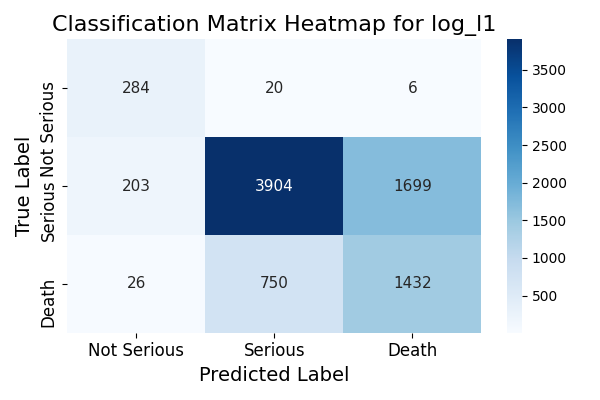

In [55]:
display(Image(filename=log_l1_img_path))

#### Other Model Metrics - Model Coefficient Odds for Each Outcome

In [56]:
def get_model_coefficients_and_odds(data, model_name, top_n=5):
    outcomes = ['Non-Serious', 'Serious', 'Death']
    result = {}

    for i, outcome in enumerate(outcomes):
        # Intercept
        intercept_data = {'Feature': ['Intercept'], 'LogOdds': [model_name.intercept_[i]]}
        intercept_df = pd.DataFrame(intercept_data)
        intercept_df['Odds'] = np.exp(intercept_df['LogOdds'])

        # Coefficients
        coef_data = {'Feature': data.columns, 'LogOdds': model_name.coef_[i]}
        coef_df = pd.DataFrame(coef_data)
        coef_df = coef_df.reindex(coef_df['LogOdds'].abs().sort_values(ascending=False).index)
        coef_df['Odds'] = np.exp(coef_df['LogOdds'])

        # Combine intercept and coefficients
        df = pd.concat([intercept_df, coef_df])
        
        result[outcome] = df.head(top_n + 1)

    return result

In [57]:
coefficients_and_odds = get_model_coefficients_and_odds(X_train_under, log_l1)
for outcome, df in coefficients_and_odds.items():
     print(f"Top features for {outcome}:")
     print(df)

Top features for Non-Serious:
             Feature   LogOdds       Odds
0          Intercept -1.491399   0.225058
4        expedited_2  4.601314  99.615123
1284  ndc9_684620226  4.336050  76.405111
752   ndc9_502420150  3.861549  47.538922
305    ndc9_17300909  3.746545  42.374444
1423  ndc9_722870310  3.580134  35.878347
Top features for Serious:
              Feature   LogOdds      Odds
0           Intercept  1.014888  2.759055
1518   ndc9_782060145  1.605418  4.979939
1031   ndc9_622070922 -1.277351  0.278775
4         expedited_2 -1.277222  0.278811
1684  ndc9_6710803565  1.269664  3.559656
1321   ndc9_694890201 -1.268368  0.281290
Top features for Death:
             Feature   LogOdds      Odds
0          Intercept  0.476511  1.610446
275    ndc9_16902550  2.237060  9.365759
4        expedited_2 -2.177806  0.113290
1284  ndc9_684620226 -2.064595  0.126870
752   ndc9_502420150 -1.882532  0.152204
346    ndc9_26409567  1.773767  5.893010


In [58]:
coefficients = log_l1.coef_

# Access intercept
intercept = log_l1.intercept_

print("Coefficients:\n", coefficients)
print("Intercept:\n", intercept)

Coefficients:
 [[ 0.00000000e+00 -2.94080594e-01 -1.00219802e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.82106920e-01  0.00000000e+00  1.36444290e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.36002805e-02  7.67819104e-02  7.13546055e-06 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Intercept:
 [-1.49139931  1.01488822  0.47651109]


### Logistic Regression L2 Regularization

#### Generate and Fit Model on Training Data

In [95]:
log_l2 = LogisticRegression(solver='saga', penalty='l2', random_state=1)
log_l2.fit(X_train_under, y_train_under)

LogisticRegression(random_state=1, solver='saga')

#### Fit Model on Testing Data, Model Performance Metrics

In [96]:
model_name = 'log_l2'

# Run model on test data, generate confusion matrix, save y_pred
log_l2_metrics_df, log_l2_img_path, log_l2_y_pred = evaluate_model(log_l2, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

log_l2_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,log_l2,0,0.675,0.550,0.916,0.688,0.997
1,log_l2,1,0.675,0.838,0.669,0.744,0.479
2,log_l2,2,0.675,0.457,0.657,0.539,0.853


#### Get Probabilities for AUC Curve

In [97]:
log_l2_y_pred_proba = log_l2.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

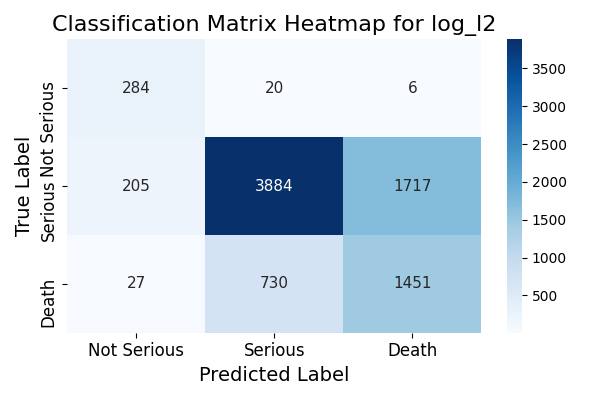

In [98]:
display(Image(filename=log_l2_img_path))

#### Other Metrics - Model Coefficient Odds for Each Outcome

In [99]:
coefficients_and_odds = get_model_coefficients_and_odds(X_train_under, log_l2)
for outcome, df in coefficients_and_odds.items():
     print(f"Top features for {outcome}:")
     print(df)

Top features for Non-Serious:
             Feature   LogOdds       Odds
0          Intercept -1.349038   0.259490
4        expedited_2  4.009946  55.143866
1284  ndc9_684620226  3.581167  35.915424
752   ndc9_502420150  3.221911  25.075999
305    ndc9_17300909  2.861545  17.488531
1423  ndc9_722870310  2.753177  15.692415
Top features for Serious:
             Feature   LogOdds      Odds
0          Intercept  0.952094  2.591129
4        expedited_2 -1.601057  0.201683
1284  ndc9_684620226 -1.523479  0.217952
1031  ndc9_622070922 -1.494444  0.224373
1518  ndc9_782060145  1.459874  4.305416
305    ndc9_17300909 -1.254645  0.285177
Top features for Death:
             Feature   LogOdds      Odds
0          Intercept  0.396944  1.487273
4        expedited_2 -2.408889  0.089915
1284  ndc9_684620226 -2.057688  0.127749
752   ndc9_502420150 -2.001721  0.135103
275    ndc9_16902550  1.769828  5.869846
305    ndc9_17300909 -1.606901  0.200508


### Logistic Regression Elastic Net

#### Grid Search

In [101]:
param_grid = {
    'l1_ratio': [i / 9 for i in range(10)],  # 10 values from 0 to 1 (0, 0.1, 0.2, ..., 1.0)
    'C': [0.01, 0.1, 1, 10, 100]  # Different strengths of regularization
}

# Initialize the Logistic Regression model with Elastic Net penalty
log_reg_elasticnet = LogisticRegression(
    penalty='elasticnet',  # Use Elastic Net regularization
    solver='saga',        # Solver that supports Elastic Net
    random_state=1
)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg_elasticnet,
    param_grid=param_grid,
    scoring='accuracy',   # Or another metric of choice
    cv=5,                 # Number of cross-validation folds
    n_jobs=-1              # Use all available CPUs
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_under, y_train_under.values.ravel())

# Extract and print the best parameters and best score from grid search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

best_score = grid_search.best_score_
print(f"Best cross-validation score: {best_score:.3f}")

# Get the best model
elastic_net = grid_search.best_estimator_


Best parameters: {'C': 100, 'l1_ratio': 0.4444444444444444}
Best cross-validation score: 0.752


#### Generate and Fit Model on Training Data

In [102]:
elastic_net.fit(X_train_under, y_train_under)

LogisticRegression(C=100, l1_ratio=0.4444444444444444, penalty='elasticnet',
                   random_state=1, solver='saga')

#### Fit Model on Testing Data, Model Performance Metrics

In [103]:
model_name = 'elastic_net'

# Run model on test data, generate confusion matrix, save y_pred
elastic_net_metrics_df, elastic_net_img_path, elastic_net_y_pred = evaluate_model(elastic_net, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

elastic_net_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,elastic_net,0,0.671,0.536,0.923,0.678,0.997
1,elastic_net,1,0.671,0.838,0.663,0.740,0.475
2,elastic_net,2,0.671,0.455,0.658,0.538,0.853


#### Get Probabilities for AUC

In [104]:
elastic_net_y_pred_proba = elastic_net.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

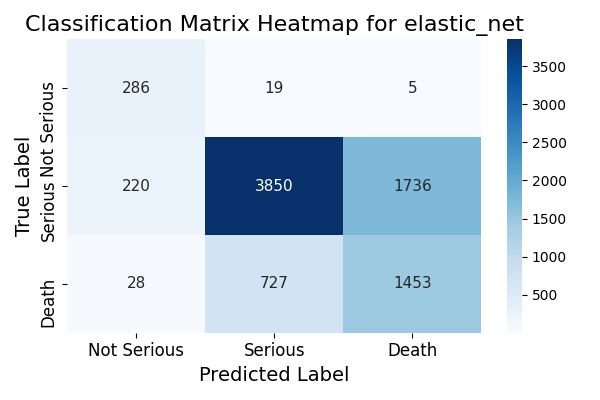

In [105]:
display(Image(filename=elastic_net_img_path))

#### Other Metrics - Model Coefficient Odds for Each Outcome

In [106]:
coefficients_and_odds = get_model_coefficients_and_odds(X_train_under, elastic_net)
for outcome, df in coefficients_and_odds.items():
     print(f"Top features for {outcome}:")
     print(df)

Top features for Non-Serious:
             Feature   LogOdds       Odds
0          Intercept -1.324891   0.265832
4        expedited_2  4.398330  81.314964
1284  ndc9_684620226  4.219960  68.030778
305    ndc9_17300909  3.826690  45.910320
752   ndc9_502420150  3.614810  37.144293
1423  ndc9_722870310  3.610317  36.977763
Top features for Serious:
             Feature   LogOdds      Odds
0          Intercept  0.933224  2.542694
1518  ndc9_782060145  2.254708  9.532512
1031  ndc9_622070922 -1.821513  0.161781
774   ndc9_504580028 -1.818574  0.162257
1321  ndc9_694890201 -1.788955  0.167135
1137  ndc9_649800449 -1.762970  0.171535
Top features for Death:
             Feature   LogOdds       Odds
0          Intercept  0.391666   1.479444
275    ndc9_16902550  2.723514  15.233757
4        expedited_2 -2.698075   0.067335
1284  ndc9_684620226 -2.655050   0.070295
346    ndc9_26409567  2.419981  11.245640
752   ndc9_502420150 -2.352679   0.095114


### Single Decision Tree

#### Grid Search

In [107]:
# Define a grid of hyperparameters to search for in tree
param_grid = {
    'max_depth' : [5,6,7,8,9,10],
    'min_samples_leaf' : [1,2,3,4,5,6]
    
}
# Create a GridSearchCV object using and the defined parameter grid
tree1_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=10, n_jobs=-1)

# Fit the GridSearchCV to the balanced training data to find the best hyperparameters
tree1_search.fit(X_train_under, y_train_under.values.ravel())

# Get the best hyperparameters found by the GridSearch
best_params = tree1_search.best_params_
print(f"Best parameters: {best_params}")

tree1 = tree1_search.best_estimator_


Best parameters: {'max_depth': 10, 'min_samples_leaf': 3}


#### Generate and Fit Model on Training Data

In [108]:
tree1.fit(X_train_under, y_train_under)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=3, random_state=1)

#### Fit Model on Testing Data, Model Performance Metrics

In [109]:
model_name = 'tree1'

# Run model on test data, generate confusion matrix, save y_pred
tree1_metrics_df, tree1_img_path, tree1_y_pred = evaluate_model(tree1, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

tree1_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,tree1,0,0.795,0.532,0.877,0.663,0.995
1,tree1,1,0.795,0.860,0.847,0.853,0.659
2,tree1,2,0.795,0.680,0.644,0.662,0.874


#### Get Probabilities for AUC

In [110]:
tree1_y_pred_proba = tree1.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

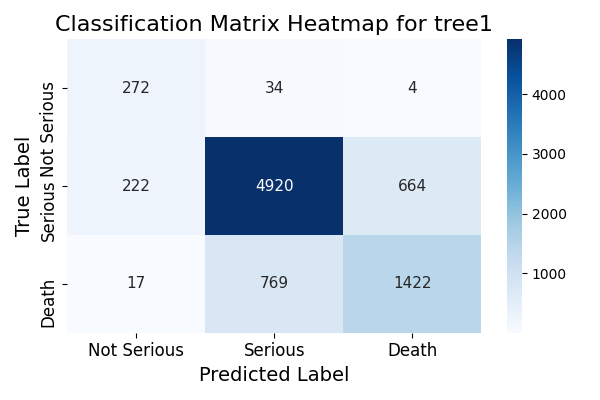

In [111]:
display(Image(filename=tree1_img_path))

#### Other Metrics - Feature Importance and Tree Structure

In [112]:
# Feature Importance Scores
# Extract feature importances
importances = tree1.feature_importances_
features = X_train_under.columns

# Create a DataFrame for better plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot for DecisionTreeClassifier')
plt.gca().invert_yaxis()  # To display the most important feature at the top
# Add labels to the bars
for bar in bars:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.4f}',
        va='center'
    )

plt.show()

In [113]:
from sklearn.tree import plot_tree
# Plot the tree structure
plt.figure(figsize=(20, 10))
plot_tree(tree1, filled=True, feature_names=X_train_under.columns, class_names=['NonSerious', 'Serious', 'Death'], rounded=True)
plt.title('Decision Tree Structure')
plt.show()

In [114]:
#Plot max_depth = 2
from sklearn.tree import plot_tree
folder_path = 'ModelOutput'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
img_path = os.path.join(folder_path, 'tree1_maxdepth2.png')

# Plot the tree structure
plt.figure(figsize=(20, 10))
plot_tree(tree1, filled=True,max_depth=2, feature_names=X_train_under.columns, class_names=['NonSerious', 'Serious', 'Death'], rounded=True)
plt.title('Decision Tree Structure')
plt.show()
plt.savefig(img_path)

In [115]:
#Plot max_depth = 1
from sklearn.tree import plot_tree
folder_path = 'ModelOutput'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
img_path = os.path.join(folder_path, 'tree1_maxdepth1.png')

# Plot the tree structure
plt.figure(figsize=(20, 10))
plot_tree(tree1, filled=True,max_depth=1, feature_names=X_train_under.columns, class_names=['NonSerious', 'Serious', 'Death'], rounded=True)
plt.title('Decision Tree Structure')
plt.show()
plt.savefig(img_path)

## Ensembles

### Random Forest Classifier w/ 5-k CV

#### Grid Search

In [61]:
start_time = time.time()


param_grid = {
    'n_estimators': [100, 125, 150, 175, 200]  # Example range for number of estimators
}

# Initialize the Random Forest Classifier
random_forest = RandomForestClassifier(random_state=1)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=random_forest,
                           param_grid=param_grid,
                           cv=5,  # Number of cross-validation folds
                           scoring='accuracy',  # Use accuracy as the scoring metric
                           n_jobs=-1,  # Use all available cores
                           verbose=2)  # Print progress messages

# Fit GridSearchCV to the data
grid_search.fit(X_train_under, y_train_under.values.ravel())

# Get the best model from the grid search
rf = grid_search.best_estimator_

rf.fit(X_train_under, y_train_under)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Example: Printing the best model parameters
print("Best Random Forest Model:")
print(rf)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'n_estimators': 150}
Best Score: 0.8618672485923395
Best Random Forest Model:
RandomForestClassifier(n_estimators=150, random_state=1)
52.70383095741272


#### Fit Model on Testing Data, Model Performance Metrics

In [62]:
model_name = 'rf'

# Run model on test data, generate confusion matrix, save y_pred
rf_metrics_df, rf_img_path, rf_y_pred = evaluate_model(rf, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

rf_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,rf,0,0.83,0.580,0.939,0.717,0.998
1,rf,1,0.83,0.918,0.835,0.875,0.685
2,rf,2,0.83,0.696,0.803,0.746,0.925


In [63]:
X_train_encoded

,weight,age,unit_price,sex_2,expedited_2,report_source_1,report_source_2,report_source_3,ndc9_200152,ndc9_200213,...,ndc9_7359409301,ndc9_7467605902,ndc9_7632901912,ndc9_7632903318,ndc9_7632908261,ndc9_7948100090,ndc9_8076200021,ndc9_8215400449,ndc9_8224301001,ndc9_8322200200
0,0.732167,0.387762,-0.100251,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.083179,-0.109440,-0.100251,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.521945,-0.009999,1.005885,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.293401,-0.208880,-0.100251,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2.734080,-2.595450,-0.100251,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66584,0.205648,0.686083,-0.100251,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66585,-0.233117,0.188881,-0.100251,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66586,0.161772,0.139161,-0.100251,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66587,-2.646327,-2.645170,-0.100251,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Get Probabilities for AUC

In [118]:
rf_y_pred_proba = rf.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

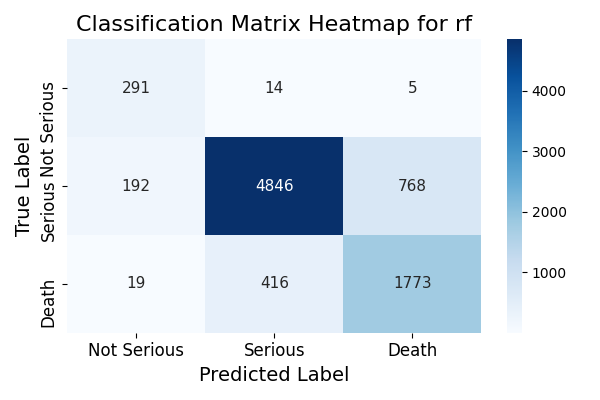

In [119]:
display(Image(filename=rf_img_path))

#### Other Metrics

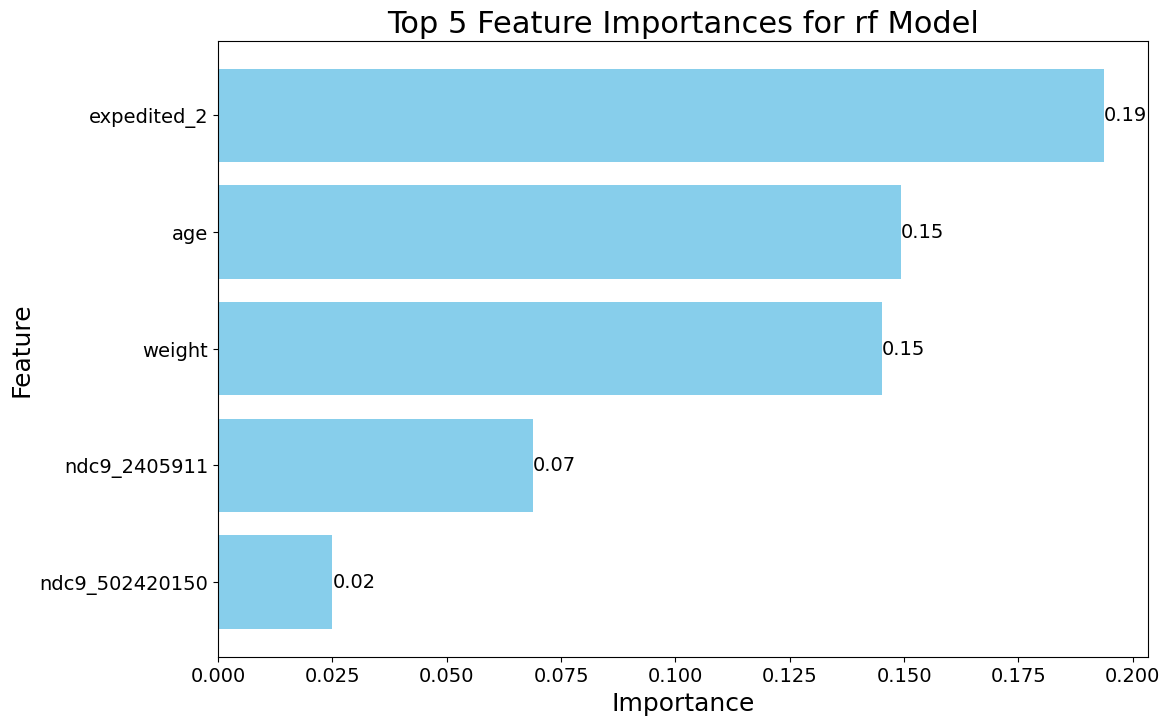

In [156]:
# Get the feature importances
importances = rf.feature_importances_

# Get the feature names
feature_names = X_train_encoded.columns

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Select the top 5 features
top_n = 5
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_feature_names = feature_names[top_indices]

# Plot the top 5 feature importances
plt.figure(figsize=(12, 8))  # Increased figure size for better readability
bars = plt.barh(top_feature_names, top_importances, color='skyblue', align='center')

# Add data labels
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}', 
             va='center', ha='left', color='black', fontsize=14)

# Customize plot appearance
plt.title('Top 5 Feature Importances for rf Model', fontsize=22)
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)
plt.gca().invert_yaxis()  # To display the highest importance at the top

# Set tick labels font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()

### Gradient Boosted Tree w/ 10-k CV

#### Grid Search

In [120]:
start_time = time.time()

# Define a grid of hyperparameters to search for in the Gradient Boosting Classifier
param_grid = {
    'max_depth' : [5,6,7,8,9,10],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1],
    'n_estimators' : [50,75,100,125,150],
}
# Create a GridSearchCV object using GradientBoostingClassifier and the defined parameter grid
tree_search = GridSearchCV(GradientBoostingClassifier(random_state=1), param_grid, cv=10, n_jobs=-1)
# Fit the GridSearchCV to the balanced training data to find the best hyperparameters
tree_search.fit(X_train_under, y_train_under.values.ravel())
# Get the best hyperparameters found by the GridSearch
tree_search.best_params_

grboost = tree_search.best_estimator_


# Print the best parameters and the best score
print("Best Parameters:", tree_search.best_params_)
print("Best Score:", tree_search.best_score_)

# Example: Printing the best model parameters
print("Best Gradient Boosted Tree:")
print(grboost)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 125}
Best Score: 0.861617842464695
Best Gradient Boosted Tree:
GradientBoostingClassifier(max_depth=10, n_estimators=125, random_state=1)
10459.68140912056


#### Fit Model on Testing Data, Model Performance Metrics

In [121]:
model_name = 'grboost'

# Run model on test data, generate confusion matrix, save y_pred
grboost_metrics_df, grboost_img_path, grboost_y_pred = evaluate_model(grboost, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

grboost_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,grboost,0,0.843,0.620,0.923,0.742,0.997
1,grboost,1,0.843,0.918,0.854,0.885,0.710
2,grboost,2,0.843,0.719,0.801,0.758,0.925


#### Get probabilities for AUC

In [122]:
grboost_y_pred_proba = grboost.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

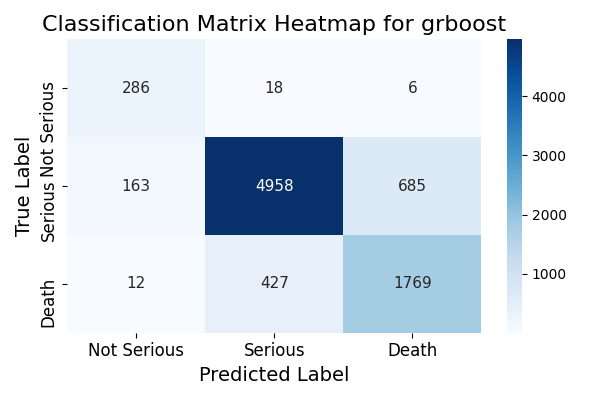

In [123]:
display(Image(filename=grboost_img_path))

#### Other Metrics

In [124]:
# Get feature importance scores
importances=grboost.feature_importances_
feature_importance_pairs=list(zip(X_train_under.columns, importances))

# Sort in descending order
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Print scores
print("Feature Importance Scores")
for feature, importance in sorted_feature_importance_pairs:
     print(f"{feature}: {importance:.4f}")

Feature Importance Scores
expedited_2: 0.3821
weight: 0.2068
age: 0.1406
ndc9_502420150: 0.0396
ndc9_684620226: 0.0275
sex_2: 0.0159
report_source_1: 0.0102
report_source_3: 0.0095
ndc9_622070922: 0.0068
unit_price: 0.0061
report_source_2: 0.0051
ndc9_722870310: 0.0048
ndc9_17300909: 0.0042
ndc9_690970897: 0.0042
ndc9_6923801146: 0.0037
ndc9_203002: 0.0028
ndc9_649800449: 0.0026
ndc9_605363: 0.0021
ndc9_724260118: 0.0020
ndc9_502420040: 0.0020
ndc9_628560704: 0.0020
ndc9_433760322: 0.0020
ndc9_603026: 0.0018
ndc9_621350442: 0.0018
ndc9_688170134: 0.0016
ndc9_1901323: 0.0016
ndc9_9307442: 0.0015
ndc9_595720501: 0.0015
ndc9_5556609800: 0.0015
ndc9_504580028: 0.0015
ndc9_7400561: 0.0014
ndc9_7077101701: 0.0014
ndc9_6050506282: 0.0014
ndc9_6768402000: 0.0014
ndc9_14309606: 0.0013
ndc9_511440020: 0.0013
ndc9_655970406: 0.0012
ndc9_502420917: 0.0012
ndc9_605055: 0.0010
ndc9_658620927: 0.0010
ndc9_502420096: 0.0010
ndc9_502420060: 0.0010
ndc9_7012101218: 0.0010
ndc9_7800846: 0.0009
ndc9_71894

## Non-parametric

### K-Nearest Neighbors Classifier

#### Grid Search

In [125]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]  # Example range for number of neighbors
}

# Initialize the K-Nearest Neighbors Classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search_knn = GridSearchCV(estimator=knn,
                               param_grid=param_grid,
                               cv=5,  # Number of cross-validation folds
                               scoring='accuracy',  # Use accuracy as the scoring metric
                               n_jobs=-1,  # Use all available cores
                               verbose=2)  # Print progress messages

# Fit GridSearchCV to the data
grid_search_knn.fit(X_train_under, y_train_under.values.ravel())

# Get the best model from the grid search
knn = grid_search_knn.best_estimator_

# Print the best parameters and the best score
print("Best Parameters for KNN:", grid_search_knn.best_params_)
print("Best Score for KNN:", grid_search_knn.best_score_)

# Example: Printing the best model parameters
print("Best KNN Model:")
print(knn)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best Parameters for KNN: {'n_neighbors': 1}
Best Score for KNN: 0.8020638726813416
Best KNN Model:
KNeighborsClassifier(n_neighbors=1)


#### Fit Model on Testing Data, Model Performance Metrics

In [126]:
model_name = 'knn'

# Run model on test data, generate confusion matrix, save y_pred
knn_metrics_df, knn_img_path, knn_y_pred = evaluate_model(knn, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

knn_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,knn,0,0.741,0.380,0.939,0.541,0.997
1,knn,1,0.741,0.896,0.722,0.800,0.557
2,knn,2,0.741,0.587,0.764,0.664,0.905


#### Get Probabilities for AUC

In [127]:
knn_y_pred_proba = knn.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

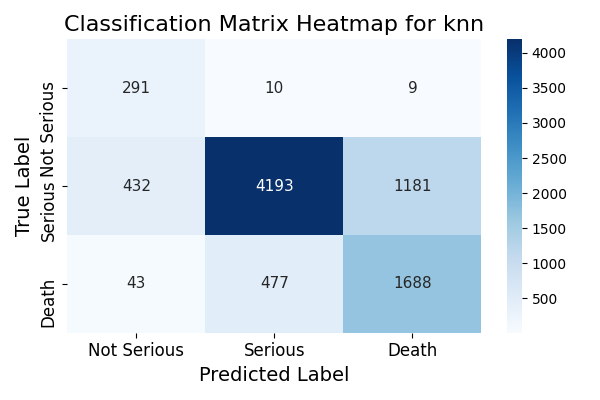

In [128]:
display(Image(filename=knn_img_path))

#### Other Metrics

### Neural Network

In [129]:
# train

In [130]:
# feature importance

In [131]:
# 

### Baseline

In [132]:
from sklearn.dummy import DummyClassifier

baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_test_encoded, y_test)
baseline_metrics_df, baseline_img_path, _ = evaluate_model(
    baseline_model, X_test_encoded, y_test, labels=[0, 1, 2], model_name='Baseline'
)
baseline_metrics_df

,model,class,accuracy,precision,recall,f1_score,specificity
0,Baseline,0,0.698,0.000,0.0,0.000,0.963
1,Baseline,1,0.698,0.698,1.0,0.822,NaN
2,Baseline,2,0.698,0.000,0.0,0.000,0.735


# Performance Metrics Table

In [137]:
def display_model_metrics_table(metrics_dfs):
    # Concatenate all DataFrames
    combined_df = pd.concat(metrics_dfs, ignore_index=True)
    
    # Convert DataFrame to a list of lists for tabulate
    table = combined_df.values.tolist()
    
    # Get column headers from DataFrame
    headers = combined_df.columns.tolist()
    
    # Generate and print the table
    table_str = tabulate(table, headers, tablefmt='pretty')
    print(table_str)
    return combined_df

model_metrics = display_model_metrics_table([baseline_metrics_df,log_l1_metrics_df, log_l2_metrics_df, elastic_net_metrics_df,
                           tree1_metrics_df, rf_metrics_df, knn_metrics_df, grboost_metrics_df])  # grboost_metrics_df

+-------------+-------+----------+-----------+--------+----------+-------------+
|    model    | class | accuracy | precision | recall | f1_score | specificity |
+-------------+-------+----------+-----------+--------+----------+-------------+
|  Baseline   |   0   |  0.698   |    0.0    |  0.0   |   0.0    |    0.963    |
|  Baseline   |   1   |  0.698   |   0.698   |  1.0   |  0.822   |     nan     |
|  Baseline   |   2   |  0.698   |    0.0    |  0.0   |   0.0    |    0.735    |
|   log_l1    |   0   |  0.675   |   0.554   | 0.916  |   0.69   |    0.997    |
|   log_l1    |   1   |  0.675   |   0.835   | 0.672  |  0.745   |    0.479    |
|   log_l1    |   2   |  0.675   |   0.456   | 0.649  |  0.536   |    0.85     |
|   log_l2    |   0   |  0.675   |   0.55    | 0.916  |  0.688   |    0.997    |
|   log_l2    |   1   |  0.675   |   0.838   | 0.669  |  0.744   |    0.479    |
|   log_l2    |   2   |  0.675   |   0.457   | 0.657  |  0.539   |    0.853    |
| elastic_net |   0   |  0.6

### Show Class Outcomes more Cleanly for Paper

Saves as csv, that can copy paste into the Excel file within the same folder. This makes it easy to paste the values into the paper

In [138]:

def format_as_percentage(df):
    # Format metrics as percentage with one decimal point
 #   df['accuracy'] = df['accuracy'].apply(lambda x: f"{x * 100:.1f}%")
    df['precision'] = df['precision'].apply(lambda x: f"{x * 100:.1f}%")
    df['recall'] = df['recall'].apply(lambda x: f"{x * 100:.1f}%")
    df['specificity'] = df['specificity'].apply(lambda x: f"{x * 100:.1f}%")
    df['f1_score'] = df['f1_score'].apply(lambda x: f"{x * 100:.1f}%")
    return df

model_metrics = format_as_percentage(model_metrics)

def aggregate_metrics(df):
    # Group by 'model'
    grouped = df.groupby('model').agg({
        'accuracy': 'mean',  # Average accuracy
        'precision': lambda x: x.tolist(),  # List of precision values
        'recall': lambda x: x.tolist(),  # List of recall values
        'specificity': lambda x: x.tolist(),  # List of specificity values
        'f1_score': lambda x: x.tolist()  # List of F1 scores
    }).reset_index()
    
    return grouped

# Apply aggregation function
aggregated_df = aggregate_metrics(model_metrics)




# Rename columns
aggregated_df = aggregated_df.rename(columns={
  #  'model': 'Model',
    'accuracy': 'Accuracy',
    'precision': 'Precision (class 0,1,2)',
    'recall': 'Recall (class 0,1,2)',
    'f1_score': 'F-score (class 0,1,2)',
    'specificity': 'Specificity (class 0,1,2)'
})


# Rename values in 'model' column
aggregated_df['model'] = aggregated_df['model'].replace({
    'elastic_net': 'Elastic Net',
    'knn': 'KNN',
    'tree1': 'Decision Tree',
    'log_l1': 'Lasso Regression',
    'log_l2': 'Ridge Regression',
    'rf': 'Random Forest',
    'grboost': 'Gradient Boosted Decision Tree'
    
})

aggregated_df['Accuracy'] = aggregated_df['Accuracy'] .apply(lambda x: f"{x * 100:.1f}%")

# Display the resulting DataFrame
print(aggregated_df)

#Save it as a CSV
folder_path = 'ModelOutput\withPrices'
os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, 'aggregated_metrics_withpricesImputed.csv')
aggregated_df.to_csv(file_path, index=False)


                            model Accuracy Precision (class 0,1,2)  \
0                        Baseline    69.8%     [0.0%, 69.8%, 0.0%]   
1                     Elastic Net    67.1%   [53.6%, 83.8%, 45.5%]   
2  Gradient Boosted Decision Tree    84.3%   [62.0%, 91.8%, 71.9%]   
3                             KNN    74.1%   [38.0%, 89.6%, 58.7%]   
4                Lasso Regression    67.5%   [55.4%, 83.5%, 45.6%]   
5                Ridge Regression    67.5%   [55.0%, 83.8%, 45.7%]   
6                   Random Forest    83.0%   [58.0%, 91.8%, 69.6%]   
7                   Decision Tree    79.5%   [53.2%, 86.0%, 68.0%]   

    Recall (class 0,1,2) Specificity (class 0,1,2)  F-score (class 0,1,2)  
0   [0.0%, 100.0%, 0.0%]      [96.3%, nan%, 73.5%]    [0.0%, 82.2%, 0.0%]  
1  [92.3%, 66.3%, 65.8%]     [99.7%, 47.5%, 85.3%]  [67.8%, 74.0%, 53.8%]  
2  [92.3%, 85.4%, 80.1%]     [99.7%, 71.0%, 92.5%]  [74.2%, 88.5%, 75.8%]  
3  [93.9%, 72.2%, 76.4%]     [99.7%, 55.7%, 90.5%]  [54.1%, 80.0%

### AUC Curves

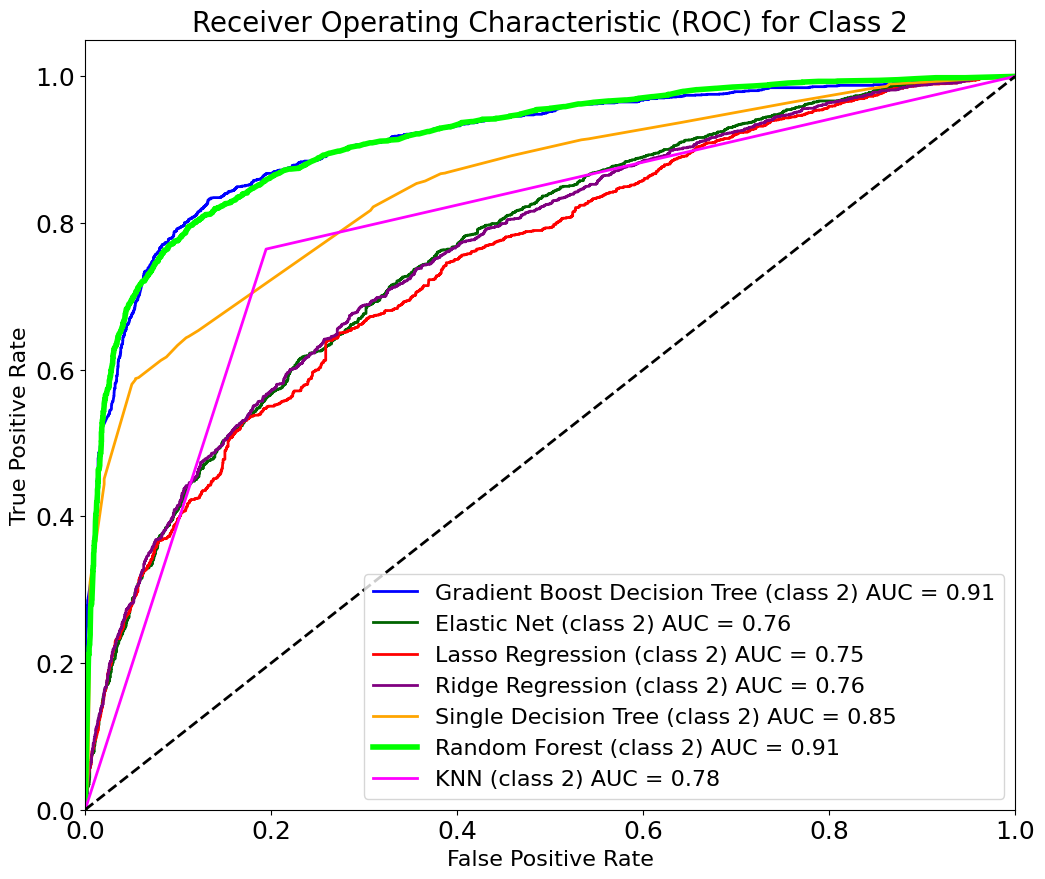

In [144]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# List of model names
model_names = ['Gradient Boost Decision Tree', 'Elastic Net', 'Lasso Regression', 'Ridge Regression', 'Single Decision Tree', 'Random Forest', 'KNN']

# List of true labels and predicted probabilities
y_tests = [y_test, y_test, y_test, y_test, y_test, y_test, y_test]  # True labels for each model
y_pred_probs = [grboost_y_pred_proba, elastic_net_y_pred_proba, log_l1_y_pred_proba, log_l2_y_pred_proba, tree1_y_pred_proba, rf_y_pred_proba, knn_y_pred_proba]  # Predicted probabilities for each model

# Colors for each model
colors = {
    'Gradient Boost Decision Tree': 'blue',
    'Elastic Net': 'darkgreen',
    'Lasso Regression': 'red',
    'Ridge Regression': 'purple',
    'Single Decision Tree': 'orange',
    'Random Forest': 'lime',  # Distinct color for Random Forest
    'KNN': 'magenta'
}

# Number of classes
n_classes = 3

# Binarize the output labels for each class
y_tests_bin = [label_binarize(y, classes=range(n_classes)) for y in y_tests]

plt.figure(figsize=(12, 10))

# Class to focus on
class_index = 2

for model_name, y_test_bin, y_pred_prob in zip(model_names, y_tests_bin, y_pred_probs):
    # Compute ROC curve and ROC area for the specific class
    fpr, tpr, _ = roc_curve(y_test_bin[:, class_index], y_pred_prob[:, class_index])
    roc_auc = auc(fpr, tpr)
    
    # Set line width and color based on model
    if model_name == 'Random Forest':
        lw = 4  # Thicker line for Random Forest
        color = colors.get(model_name, 'black')  # Color for Random Forest
    else:
        lw = 2  # Default line width
        color = colors.get(model_name, 'black')  # Default color for other models

    # Plot ROC curve for the specific class
    plt.plot(fpr, tpr, lw=lw, color=color, label=f'{model_name} (class {class_index}) AUC = {roc_auc:.2f}')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set axis labels and title with font sizes
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic (ROC) for Class 2', fontsize=20)

# Adjust the size of the axis ticks and legend
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc="lower right", fontsize=16)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

folder_path = 'ModelOutput\withPrices'
img_path = os.path.join(folder_path, 'ROCPlotImputation.png')
plt.savefig(img_path)

plt.show()


# Top Model Performance on Validation Data

In [44]:
y_val

,serious_outcome
59905,2
57542,2
68996,1
66708,2
24436,1
...,...
76229,1
19377,1
80539,1
9416,1


In [51]:
model_name = 'rf'

# Run model on test data, generate confusion matrix, save y_pred
rf_metrics_df_val, rf_img_path_val, rf_y_pred_val = evaluate_model(rf, X_val_encoded, y_val, labels=[0, 1, 2], model_name=model_name)

rf_metrics_df_val.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,rf,0,0.833,0.576,0.975,0.724,0.999
1,rf,1,0.833,0.931,0.828,0.877,0.674
2,rf,2,0.833,0.687,0.826,0.750,0.936


[CV] END ...................................n_estimators=100; total time=  10.9s
[CV] END ...................................n_estimators=125; total time=  16.8s
[CV] END ...................................n_estimators=175; total time=  13.9s
[CV] END ...................................n_estimators=125; total time=  12.8s
[CV] END ...................................n_estimators=150; total time=  17.2s
[CV] END ...................................n_estimators=175; total time=  13.3s
[CV] END ...................................n_estimators=100; total time=  10.6s
[CV] END ...................................n_estimators=150; total time=  18.6s
[CV] END ...................................n_estimators=175; total time=  13.7s
[CV] END ...................................n_estimators=100; total time=  11.3s
[CV] END ...................................n_estimators=150; total time=  19.0s
[CV] END ...................................n_estimators=200; total time=  15.0s
[CV] END ...................

In [50]:
rf

RandomForestClassifier(n_estimators=150, random_state=1)

In [49]:
X_test_encoded

,weight,age,unit_price,sex_2,expedited_2,report_source_1,report_source_2,report_source_3,ndc9_200152,ndc9_200213,...,ndc9_7359409301,ndc9_7467605902,ndc9_7632901912,ndc9_7632903318,ndc9_7632908261,ndc9_7948100090,ndc9_8076200021,ndc9_8215400449,ndc9_8224301001,ndc9_8322200200
0,-0.452500,0.487203,-0.100561,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.847389,0.934684,-0.100251,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.565821,0.039721,-0.100251,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.496376,0.437482,-0.100251,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.847389,1.531327,-0.100251,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8319,0.995426,-0.606642,-0.100251,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8320,-0.803512,-0.755802,-0.094499,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8321,-1.242278,1.929088,-0.100251,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8322,-0.189241,0.437482,-0.066301,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
